In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from utils import *
import scipy.stats
import seaborn as sns
from ipywidgets import interact, interactive, FloatProgress, IntProgress
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, confusion_matrix

In [2]:
fx_1minute_bar_catalog()

defaultdict(list,
            {'EURGBP': ['2012', '2013', '2014', '2015', '2016'],
             'EURJPY': ['2012', '2013', '2014', '2015', '2016'],
             'EURUSD': ['2012', '2013', '2014', '2015', '2016'],
             'GBPCHF': ['2012', '2013', '2014', '2015', '2016'],
             'GBPJPY': ['2012', '2013', '2014', '2015', '2016'],
             'GBPUSD': ['2012', '2013', '2014', '2015', '2016'],
             'USDJPY': ['2012', '2013', '2014', '2015', '2016'],
             'XAGUSD': ['2012', '2013', '2014', '2015', '2016'],
             'XAUGBP': ['2012', '2013', '2014', '2015', '2016'],
             'XAUUSD': ['2012', '2013', '2014', '2015', '2016']})

In [3]:
ds = load_1minute_fx_bars('XAUUSD', 2012)[['close']]
ds.head()

,close
ts,
2012-01-02 18:03:00,1568.54
2012-01-02 18:04:00,1568.01
2012-01-02 18:05:00,1568.35
2012-01-02 18:06:00,1568.28
2012-01-02 18:07:00,1567.78


In [4]:
def masig(x, lp, sp):
    volp = lp*5
    lma = x.rolling(lp).mean()
    sma = x.rolling(sp).mean()
    return np.tanh(10000 * (sma - lma) * lma.rolling(volp).std() / (np.sqrt(lp) *sma.rolling(volp).std()))

In [5]:
def ewmasig(x, lp, sp):
    volp = lp*5
    lma = x.ewm(span=lp).mean()
    sma = x.ewm(span=sp).mean()
    return np.tanh(15000 * (sma - lma) * lma.ewm(volp).std() / (np.sqrt(lp) *sma.ewm(volp).std()))

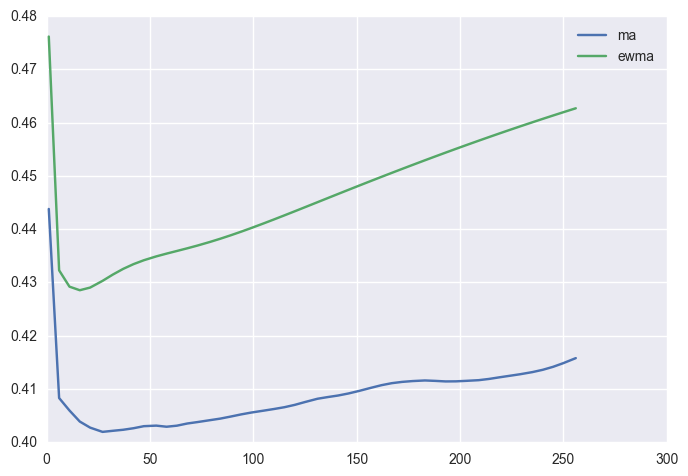

In [6]:
xs = []
ys1 = []
ys2 = []
ret = logreturn(ds['close'], ds['close'].shift(1))
px = ret.cumsum()
for a in np.linspace(1,256,50):
    a = int(a)
    xs.append(a)
    ys1.append(masig(px, 2*a,a).std())
    ys2.append(ewmasig(px, 2*a,a).std())
plt.plot(xs,ys1, label='ma')
plt.plot(xs,ys2, label='ewma')
plt.legend()

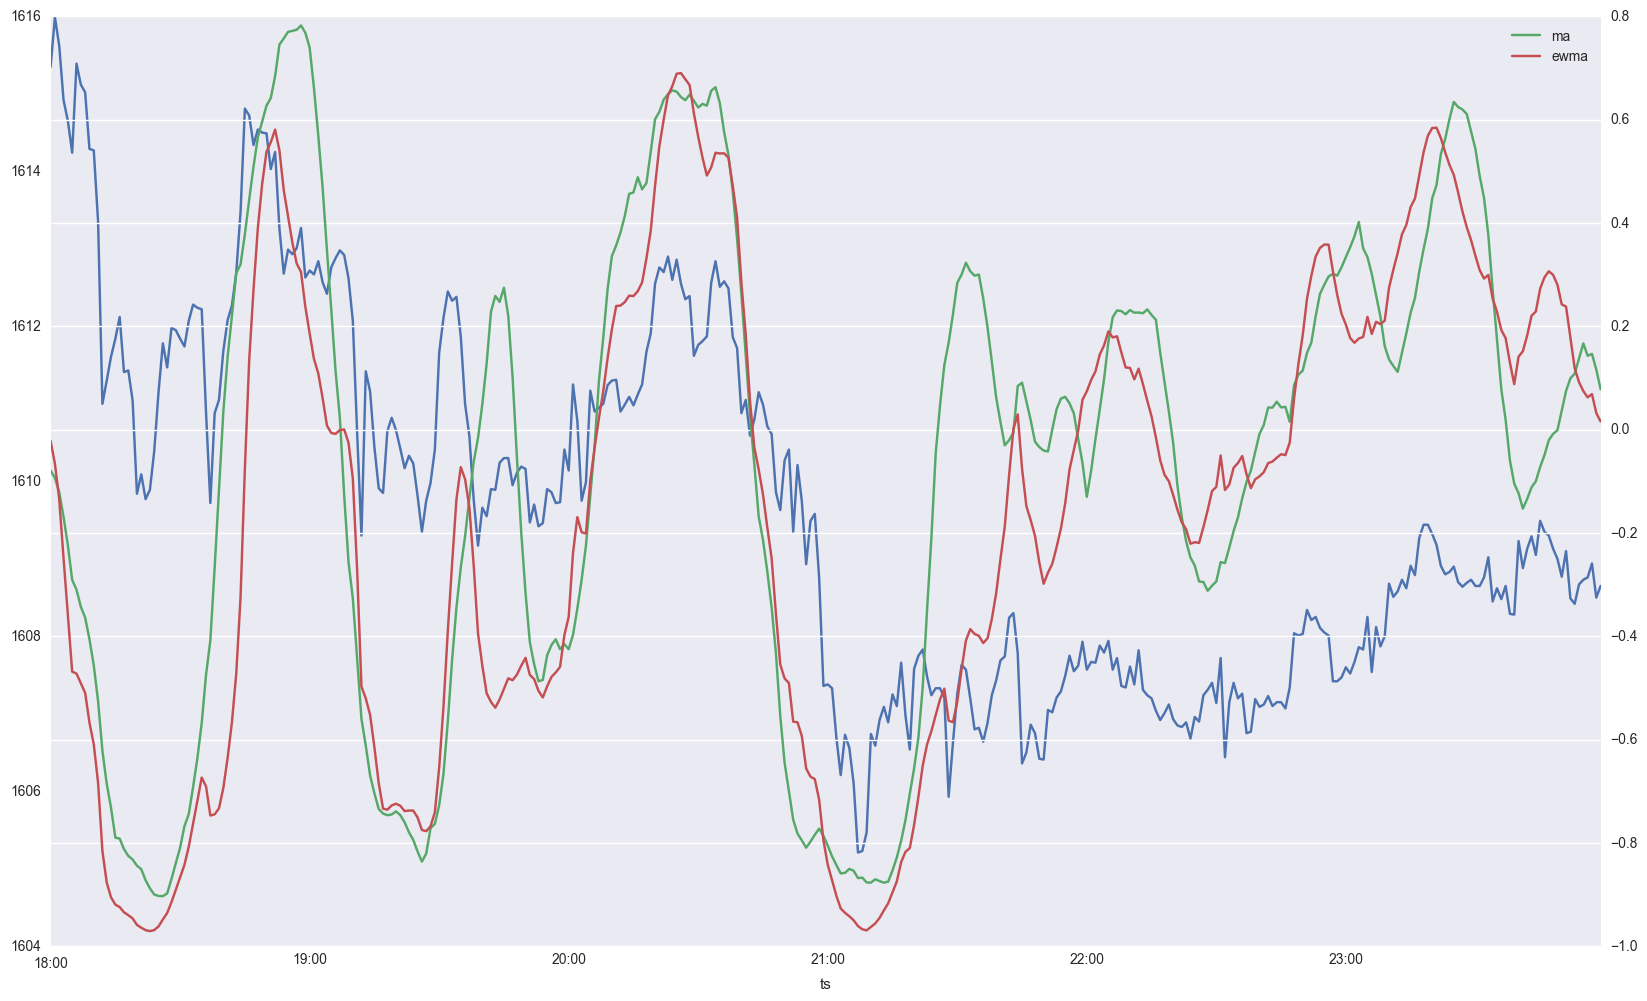

In [7]:

DATE='2012-01-08'
FIGSIZE=(20,12)
plt.figure(figsize=FIGSIZE)

ret = logreturn(ds['close'], ds['close'].shift(1))
px = ret.cumsum()
ds['ma'] = masig(px, 32,16)
ds['ewma'] = ewmasig(px, 32,16)
#ds['ma4-2'] = 3*(ds['ma4']-ds['ma2'])*(ds['ma4'].rolling(1000).std()/ds['ma2'].rolling(1000).std())
#ds['sd4'] = ds['ma4'].std()
#ds['sd2'] = ds['ma2'].std()
#ds['sddiff'] = ds['sd2']-ds['sd4']
ds[DATE]['close'].plot(label='close')
ds[DATE]['ma'].plot(secondary_y=True)
ds[DATE]['ewma'].plot(secondary_y=True)
plt.legend()



- n.b. lret here seems to be double log'ing..

In [8]:
years = [2012,2013,2014]
syms = fx_1minute_bar_catalog().keys()
dsall = None
for sym in syms:
    for year in years:
        ds = load_1minute_fx_bars(sym, year)[['close']]
        px = logreturn(ds['close'], ds['close'].shift(1)).cumsum()
        ds['px'] = px
        for period in [2,4,8,16,32,64,128,256]:
            ds['lret-{}'.format(period)] = np.tanh(logreturn(px, px.shift(period)))
            ds['ma{}-{}'.format(2*period, period)] = masig(px, 2*period, period)
            ds['ewma{}-{}'.format(2*period, period)] = ewmasig(px, 2*period, period)
        if dsall is None:
            dsall = ds
        else:
            dsall = dsall.append(ds)
    

utils.py:109: RuntimeWarning: invalid value encountered in log
  return np.log(px_latest / px_prev)


KeyboardInterrupt: 

In [196]:
ds = dsall.drop('close', axis=1)

In [1]:
filename = 'moving_avg_2012-2014.h5'

In [200]:
ds.to_hdf(filename,'w')

In [2]:
ds = pd.read_hdf(filename)

NameError: name 'pd' is not defined

In [12]:
print len(ds)
ds.head(3)

10911797


,px,lret-2,ma4-2,ewma4-2,lret-4,ma8-4,ewma8-4,lret-8,ma16-8,ewma16-8,...,ewma64-32,lret-64,ma128-64,ewma128-64,lret-128,ma256-128,ewma256-128,lret-256,ma512-256,ewma512-256
ts,,,,,,,,,,,,,,,,,,,,,
2012-01-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02 02:01:00,0.000161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02 02:02:00,0.000030,NaN,NaN,-0.101682,NaN,NaN,-0.038941,NaN,NaN,-0.014454,...,-0.001884,NaN,NaN,-0.000671,NaN,NaN,-0.000238,NaN,NaN,-0.000084


In [13]:
ds.head(100000).describe()

,px,lret-2,ma4-2,ewma4-2,lret-4,ma8-4,ewma8-4,lret-8,ma16-8,ewma16-8,...,ewma64-32,lret-64,ma128-64,ewma128-64,lret-128,ma256-128,ewma256-128,lret-256,ma512-256,ewma512-256
count,99999.000000,9.986100e+04,99977.000000,99998.000000,9.978000e+04,99953.000000,99998.000000,99686.000000,99905.000000,99998.000000,...,99998.000000,99128.000000,99233.000000,99998.000000,98620.000000,98465.000000,99998.000000,97851.000000,96929.000000,99998.000000
mean,0.046622,2.066938e-04,0.002754,0.005232,3.512091e-04,0.004750,0.008039,0.000626,0.007043,0.011726,...,0.023541,0.001751,0.020979,0.032657,0.003508,0.029050,0.044321,0.007427,0.039924,0.058518
std,0.042685,6.047123e-02,0.391960,0.421604,7.086686e-02,0.383602,0.410527,0.084626,0.379503,0.404722,...,0.403778,0.139587,0.374754,0.412883,0.167014,0.388078,0.427640,0.199800,0.409744,0.447629
min,-0.025439,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-0.999921,-0.999969,-1.000000,-0.999084,-0.999907,...,-0.998879,-1.000000,-0.985348,-0.996904,-1.000000,-0.996467,-0.988154,-1.000000,-0.967584,-0.962857
25%,0.006080,-3.367017e-03,-0.249591,-0.272583,-4.831684e-03,-0.239451,-0.261424,-0.006810,-0.234467,-0.246923,...,-0.225132,-0.018192,-0.211206,-0.229237,-0.024757,-0.213211,-0.225707,-0.035540,-0.225614,-0.245200
50%,0.053512,2.220446e-16,0.000002,0.005472,1.332268e-15,0.003903,0.010888,0.000084,0.009892,0.015748,...,0.031896,0.000798,0.029074,0.041591,0.002083,0.038456,0.069047,0.005138,0.059566,0.095003
75%,0.085454,3.430085e-03,0.255282,0.286412,4.929022e-03,0.252603,0.281090,0.007091,0.250740,0.278085,...,0.288520,0.019981,0.268987,0.316956,0.028792,0.295541,0.348649,0.043895,0.325107,0.399124
max,0.112724,1.000000e+00,0.999952,1.000000,1.000000e+00,0.999861,0.999885,1.000000,0.999230,0.999508,...,0.995907,1.000000,0.985037,0.990238,1.000000,0.973219,0.979802,0.999986,0.921392,0.948274


In [12]:
from sklearn.manifold import TSNE
tsne = TSNE()

In [13]:
#random sample of points
n_sample = 2000
sample_idx = np.random.choice(len(ds), n_sample)

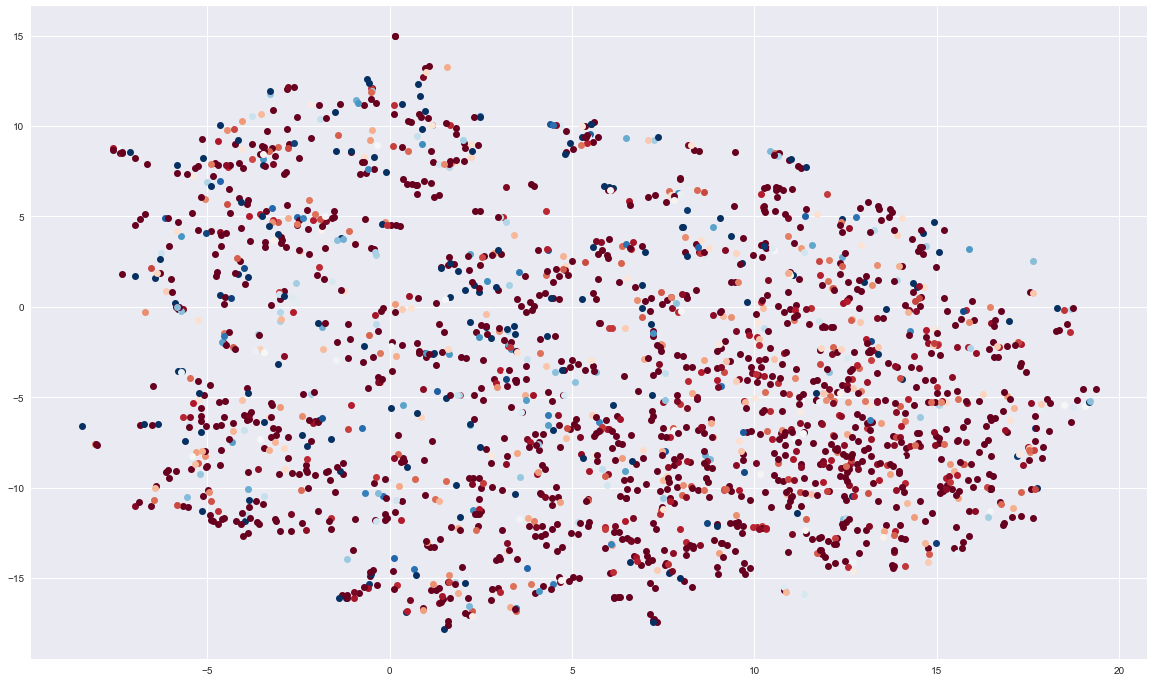

In [14]:
X = ds.fillna(0.0)
y = ds['px'].diff().shift(-10)
xt = tsne.fit(X.ix[sample_idx])

plt.figure(figsize=FIGSIZE)
c = y.ix[sample_idx]/y.ix[sample_idx].std()
for i in range(n_sample):    
    plt.plot(xt.embedding_[i,0], xt.embedding_[i,1], 'o', color=plt.cm.RdBu(c[i]))

In [14]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [16]:
n_categories = 5
X = ds.fillna(0.0)
n = len(X)
y = ds['px'].diff().shift(-10).fillna(0.0)

ntrain = int(0.95*n)
X_train = X[0:ntrain]
X_test = X[ntrain:]
y_train = y[0:ntrain]
y_train = y_train -y_train.mean()
Y_train = pd.qcut(y_train,n_categories, labels=False)

y_test = y[ntrain:]
Y_test = pd.qcut(y_test,n_categories, labels=False)


In [17]:
print "train"
print "X", X_train.shape
print "Y", Y_train.shape

print "test"
print "X", X_test.shape
print "Y", Y_test.shape

train
X (10366207, 25)
Y (10366207,)
test
X (545590, 25)
Y (545590,)


In [21]:
model = AdaBoostClassifier()
model.fit(X_train, Y_train.astype(int))

KeyboardInterrupt: 

In [ ]:
Y_pred = model.predict(X_test)
conf_matrix =  confusion_matrix(Y_test, Y_pred)
print conf_matrix
print accuracy_score(Y_test, Y_pred)
print f1_score(Y_test, Y_pred, average='weighted')
sns.heatmap(conf_matrix)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
conf_matrix =  confusion_matrix(Y_test, Y_pred)
print conf_matrix
print accuracy_score(Y_test, Y_pred)
print f1_score(Y_test, Y_pred, average='weighted')
sns.heatmap(conf_matrix)

----------------------

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.utils import np_utils


Using TensorFlow backend.


In [19]:
n_features = X_train.shape[1]
print "n_features", n_features

n_features 25


In [20]:
model = Sequential()
model.add(Dense(500, input_dim=n_features, activation='relu', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(output_dim=n_categories, activation='softmax', init='he_normal'))

#model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='mean_absolute_error', optimizer='adam')

In [21]:
from collections import defaultdict
all_history = defaultdict(list)

In [22]:
epochs=1
batch_size=80000
hist=model.fit(
    X_train.as_matrix(), np_utils.to_categorical(Y_train),
    batch_size=batch_size, nb_epoch=epochs, validation_split=0.01, verbose=2)

plt.figure(figsize=(12,6))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

Train on 10262544 samples, validate on 103663 samples
Epoch 1/1


KeyboardInterrupt: 

In [91]:
all_history['loss'].extend(hist.history['loss'])
all_history['val_loss'].extend(hist.history['val_loss'])
all_history

defaultdict(list,
            {'loss': [1.515341079055968,
              1.5153748902522655,
              1.5153282558944818,
              1.5153808128498321,
              1.515323584730448,
              1.5152923789574952,
              1.5153094642252563,
              1.5153062222505223,
              1.5153102658081983,
              1.5152467358658732,
              1.5152550081332916,
              1.515224713961838,
              1.5151589720742313,
              1.5151742728500601,
              1.5151433687140097,
              1.5152011416558788,
              1.5151314696163667,
              1.5151181158324869,
              1.5151178192811445,
              1.5150968578236474,
              1.5150895697321949,
              1.5150619059433434,
              1.5150522394902488,
              1.5150503025385769,
              1.5150388802903585,
              1.5150127584858566,
              1.5149933042512551,
              1.5150033749274538,
              1.514958992

In [92]:
import datetime as dt
timestr = dt.datetime.strftime(dt.datetime.now(), "%Y%d%m-%H%M%S")
filename = "moving_average_500_500_500_500_{}.h5".format(timestr)

model.save(filename)
print "saved model to", filename

saved model to moving_average_500_500_500_500_20173001-000455.h5


In [96]:
!ls -ltrh

total 4.5G
-rw-rw-r-- 1 andy andy  81K Dec  8 08:05 cz16.cbt.txt
-rw-rw-r-- 1 andy andy  48K Dec 16 19:33 Prob Dist Functions.ipynb
-rw-rw-r-- 1 andy andy  582 Dec 26 13:40 Untitled.ipynb
-rw-rw-r-- 1 andy andy 161K Dec 26 18:06 Explore data.ipynb
drwxrwxr-x 2 andy andy 4.0K Dec 27 18:18 stockData
-rw-rw-r-- 1 andy andy  73K Jan  4 22:37 rand_searched_rfrefressor.pkl
-rw-rw-r-- 1 andy andy 3.3M Jan  4 23:07 nn_model_500_500_no_dropout.pkl
-rw-rw-r-- 1 andy andy  18K Jan  6 08:16 DataSets.ipynb
-rw-rw-r-- 1 andy andy 320K Jan 13 07:58 Baseline Metrics of moving averages.ipynb
-rw-rw-r-- 1 andy andy 3.5M Jan 13 08:56 stockData.tgz
-rw-rw-r-- 1 andy andy 3.2K Jan 17 19:00 LoadKerasModel.ipynb
-rw-rw-r-- 1 andy andy 158K Jan 17 19:54 Volatility-Prediction-Exploration-Copy1.ipynb
-rw-rw-r-- 1 andy andy 1.8M Jan 17 22:17 rand_searched_rfregressor.pkl
drwxrwxr-x 2 andy andy 4.0K Jan 17 23:33 1000
-rw-rw-r-- 1 andy andy  25K Jan 18 07:10 prog.np
-rw-rw-r-- 1 andy andy 135K Jan 18 19:30 scratch

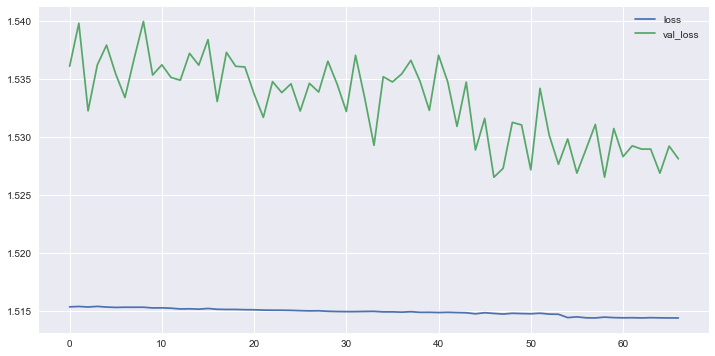

In [93]:
plt.figure(figsize=(12,6))
plt.plot(all_history['loss'], label='loss')
plt.plot(all_history['val_loss'], label='val_loss')
plt.legend()

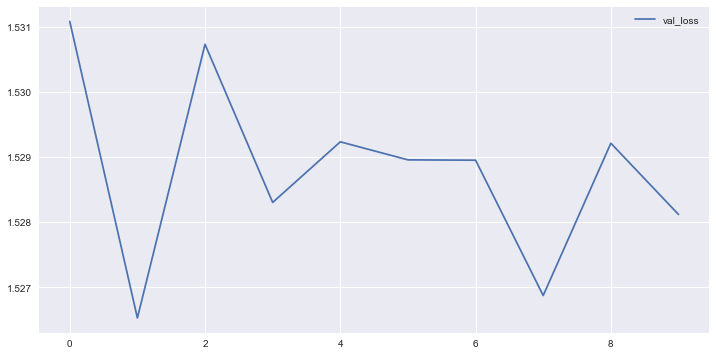

In [94]:
plt.figure(figsize=(12,6))
#plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

[[49817 11464  3536 16038 28263]
 [34542 18351 10563 25676 19988]
 [30862 19749 14822 27330 16353]
 [33890 17695 10328 26780 20426]
 [47622 11162  3583 16828 29922]]
0.256038417126
0.245028560387


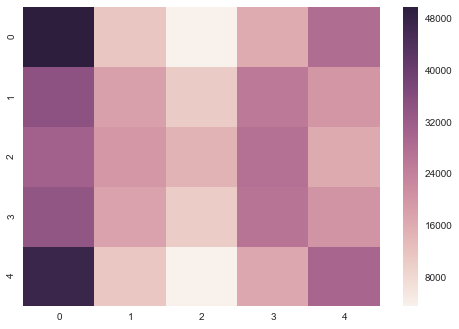

In [95]:
Y_pred = model.predict(X_test.as_matrix(), batch_size=2000, verbose=2)
pred_classes = np_utils.categorical_probas_to_classes(Y_pred)
conf_matrix =  confusion_matrix(Y_test, pred_classes)
print conf_matrix
print accuracy_score(Y_test,pred_classes)
print f1_score(Y_test,pred_classes, average='weighted')
sns.heatmap(conf_matrix)